
<h1><center><font size="8"'><strong>Exploratory Data Analysis for Tuberculosis</strong></font></center></h1>



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive



# Importing Packages

In [ ]:
!pip install split-folders
!pip install pydicom

In [ ]:
import pandas as pd
import numpy as np
import cv2
from skimage import io
from glob import glob
import os
import matplotlib.pyplot as plt
import albumentations as A

from skimage.color import label2rgb
from pathlib import Path
import seaborn as sns
plt.style.use("seaborn")
import re
import shutil
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pydicom
from PIL import Image

import warnings
warnings.simplefilter("ignore")

<ipython-input-3-6cf9a121e907>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Exploratory Data Analysis

## Code for Moving Files from Directory to Directory

In [ ]:
# source_dir = '/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Original Datasets/Kaggle Tuberculosis Chest X-Ray Database/Normal'
# target_dir = '/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Non-Tuberculosis'
# file_names = os.listdir(source_dir)

# for file_name in file_names:
#     shutil.move(os.path.join(source_dir, file_name), target_dir)


## Code for viewing and converting DICOM images

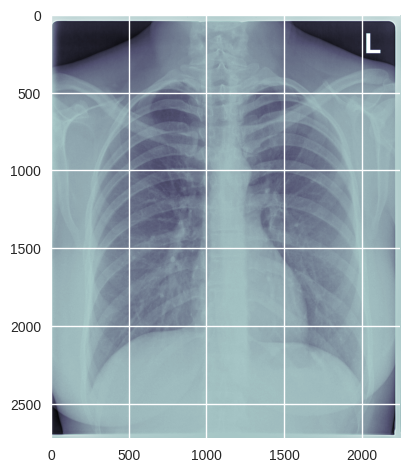

In [ ]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
filename = os.path.abspath('/gdrive/MyDrive/Datasets/Omdena Myanmar/Original Datasets/Kaggle Drug Resistant Tuberculosis X-Ray/images/images/1.2.840.114062.2.192.168.196.13.2014.12.1.12.44.11.14048671.dcm')
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

In [ ]:
# source_path = '/gdrive/MyDrive/Datasets/Omdena Myanmar/Original Datasets/Kaggle Drug Resistant Tuberculosis X-Ray/images/images'
# filename_list = os.listdir(source_path)

# i = 1
# for filename in filename_list:

#     # Load the DCM file
#     dcm = pydicom.dcmread(os.path.join(source_path, filename))

#     # Convert the pixel array to a numpy array and scale the values
#     array = dcm.pixel_array
#     array = (array / np.max(array)) * 255
#     array = array.astype(np.uint8)

#     # Create a PIL image from the numpy array
#     image = Image.fromarray(array)

#     # Save the image as a PNG file
#     path = '/gdrive/MyDrive/Datasets/Omdena Myanmar/Original Datasets/Kaggle Drug Resistant Tuberculosis X-Ray/png'
#     image.save(os.path.join(path, f"pt_{i}.png"))

#     i+=1

## Distribution of Target Variable

In [ ]:
source_path = '/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/'

source_path_tb = os.path.join(source_path, 'Tuberculosis')
source_path_ntb = os.path.join(source_path, 'Non-Tuberculosis')

print(f"There are {len(os.listdir(source_path_tb))} images of TB patients.")
print(f"There are {len(os.listdir(source_path_ntb))} images of non-TB patients.")

There are 2353 images of TB patients.
There are 7559 images of non-TB patients.


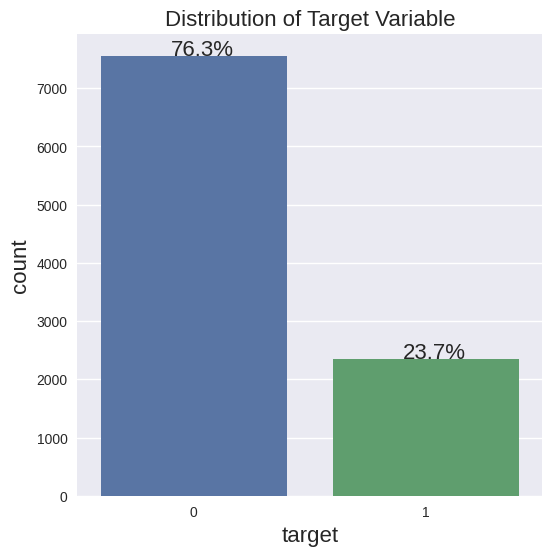

In [ ]:
ntb_list = os.listdir(source_path_ntb)
tb_list = os.listdir(source_path_tb)

non_tb_df = pd.DataFrame(ntb_list, columns=['filename'])
non_tb_df['target'] = 0
tb_df = pd.DataFrame(tb_list, columns=['filename'])
tb_df['target'] = 1

target_df = pd.concat([tb_df, non_tb_df], axis=0)

# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (6, 6))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(target_df, 'target', 'count', 'Distribution of Target Variable')

## Distributions of NIH dataset

In [ ]:
# create dataframes from the clinical diagnosis files
df_list = []

for f in glob("/gdrive/MyDrive/Datasets/Omdena Myanmar/Original Datasets/NIH Montgomery County CXR Set/ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep=':', header=None)
    df_list.append(data)

diagnoses = [x.iloc[2, 0] for x in df_list]
ages = [int(x.iloc[1, 1][2:-1]) for x in df_list]
sex = [x.iloc[0, 1][1: -1] for x in df_list]

nih_mont_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_mont_df['Source'] = 'Montgomery'

df_list = []

for f in glob("/gdrive/MyDrive/Datasets/Omdena Myanmar/Original Datasets/NIH Shenzhen Hospital CXR Set/ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep='\t', header=None)
    df_list.append(data)

diagnoses = [x.iloc[1, 0] for x in df_list]
sex_and_age = [x.iloc[0, 0] for x in df_list]
ages = [int(re.findall('\\d+', text)[0]) for text in sex_and_age]
sex = ['F' if re.search('f', text) else 'M' for text in sex_and_age]

nih_shen_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_shen_df['Source'] = 'Shenzhen'

diagnosis_df = pd.concat([nih_mont_df, nih_shen_df], axis=0)

normal_df = diagnosis_df.loc[diagnosis_df.Diagnosis=='normal']
tb_df = diagnosis_df.loc[diagnosis_df.Diagnosis!='normal']


In [ ]:
normal_df.head()

,Age,Sex,Diagnosis,Source
0,53,F,normal,Montgomery
1,70,F,normal,Montgomery
2,27,F,normal,Montgomery
3,21,F,normal,Montgomery
4,40,F,normal,Montgomery


Text(0, 0.5, 'Count')

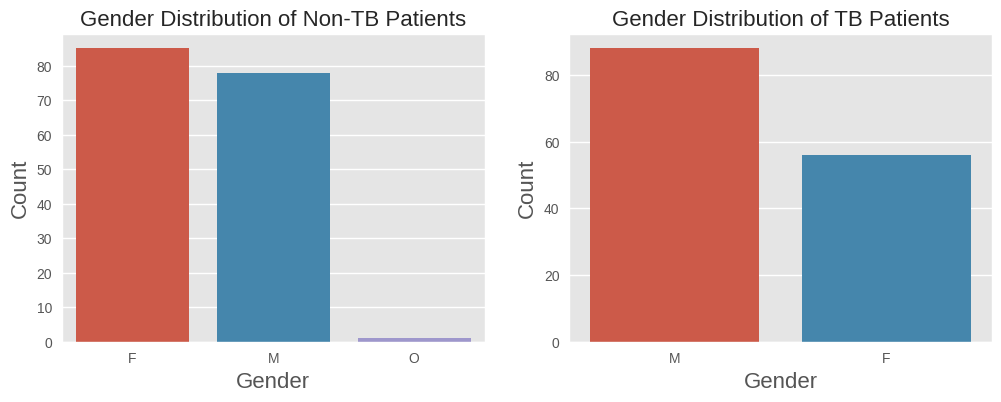

In [ ]:
# display difference in gender distribution of TB vs. non-TB patients
plt.style.use('ggplot')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='Sex', data=normal_df, ax=ax1)
b = sns.countplot(x='Sex', data=tb_df, ax=ax2)
ax1.set_title("Gender Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Gender Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Gender', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Gender', size=16)
ax2.set_ylabel('Count', size=16)

Text(0, 0.5, 'Count')

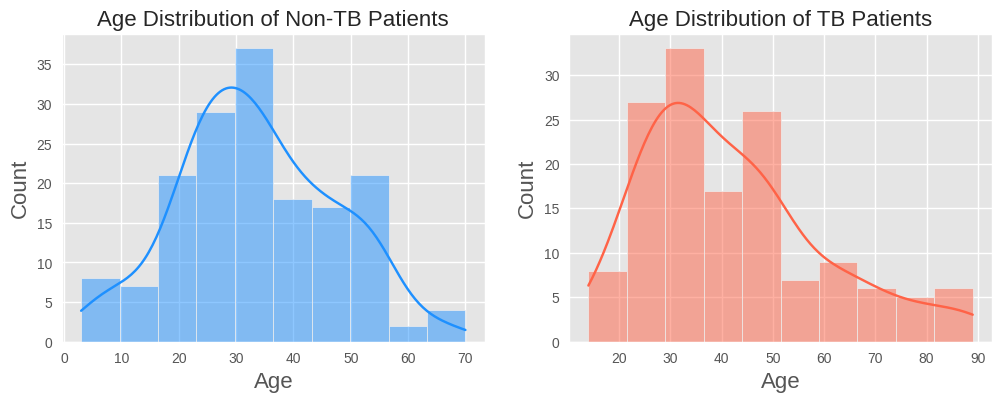

In [ ]:
# create graphs to display distribution of age for non-TB vs. TB patients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='Age', data=normal_df, kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='Age', data=tb_df, kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Age Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Age', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Age', size=16)
ax2.set_ylabel('Count', size=16)

## Non-Tuberculosis Images

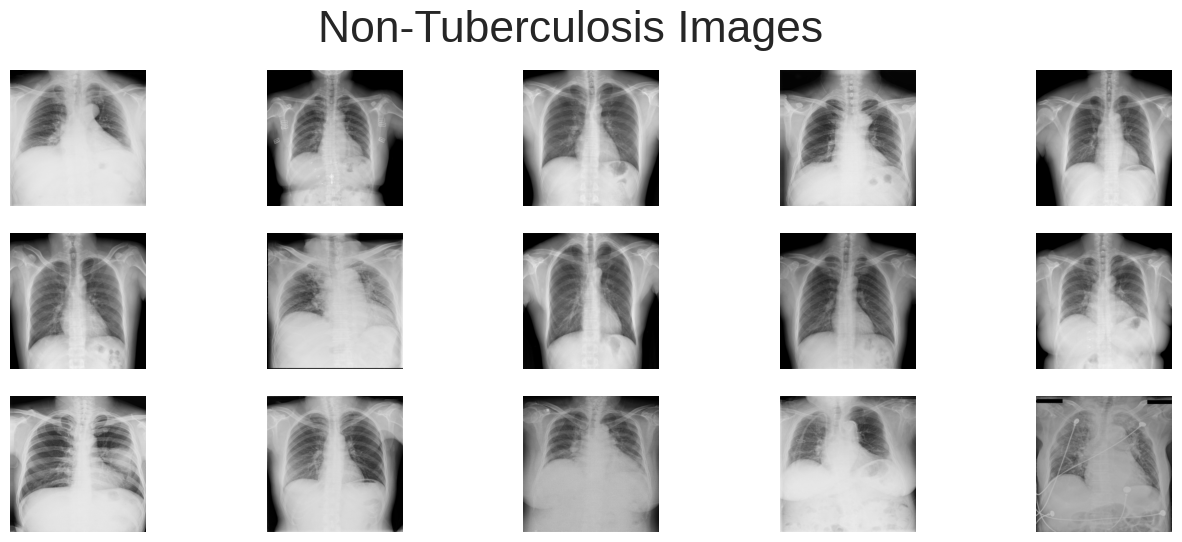

In [ ]:
# display sample of non-TB images
plt.style.use('seaborn')
paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Non-Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Non-Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Tuberculosis Images

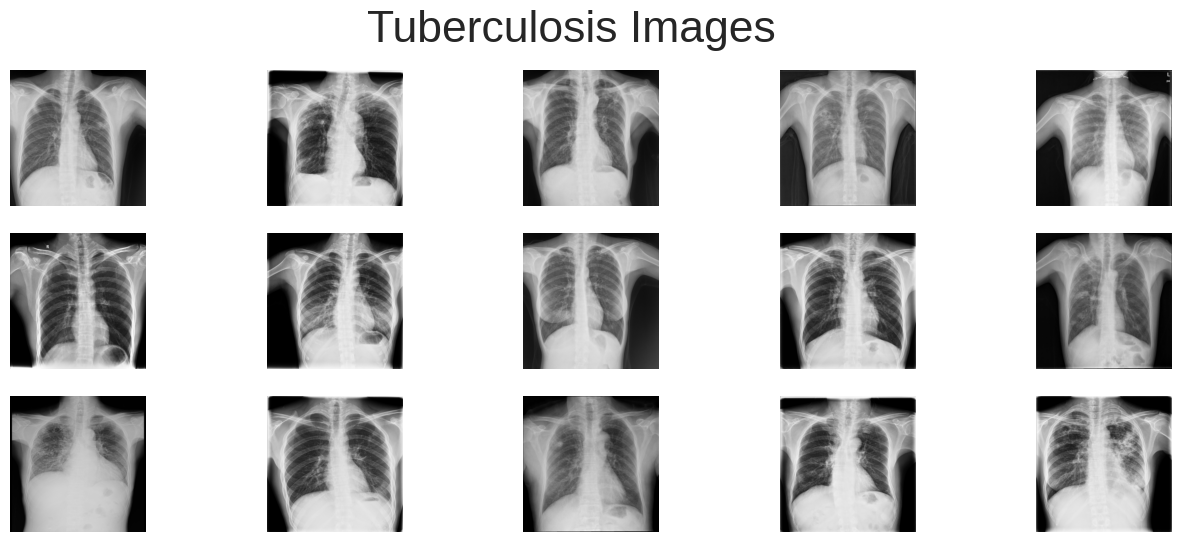

In [ ]:
# display sample of TB images
plt.style.use('seaborn')
paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Augmentation Images

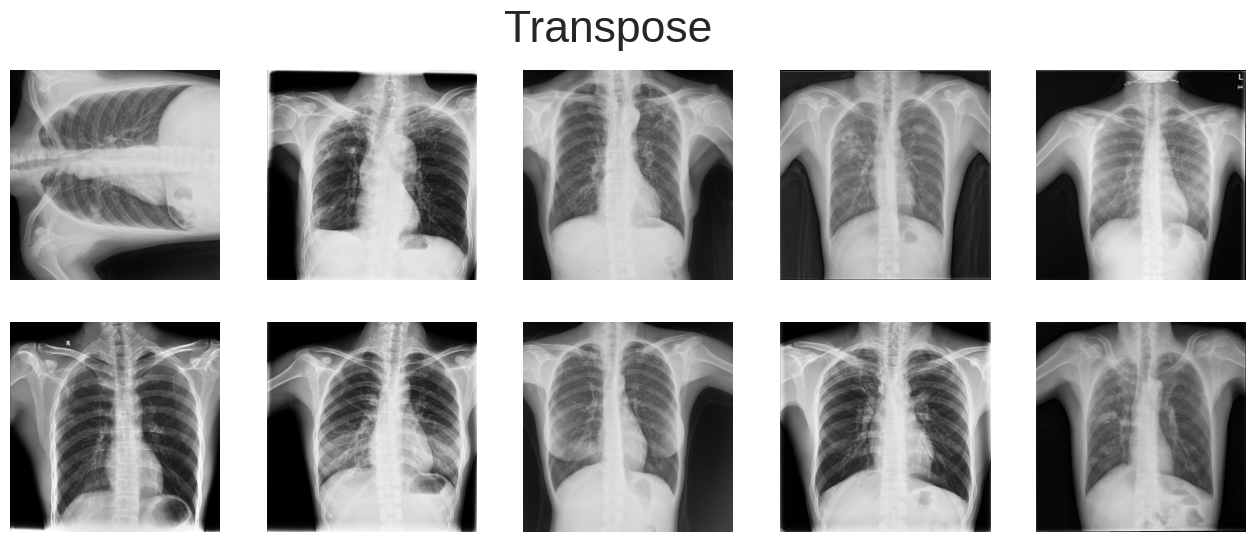

In [ ]:
# display Transpose augmentations (rotates image)
transform = A.Compose([
    A.Transpose()
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
plt.suptitle('Transpose', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    transformed = transform(image=image)
    aug_image = transformed['image']
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

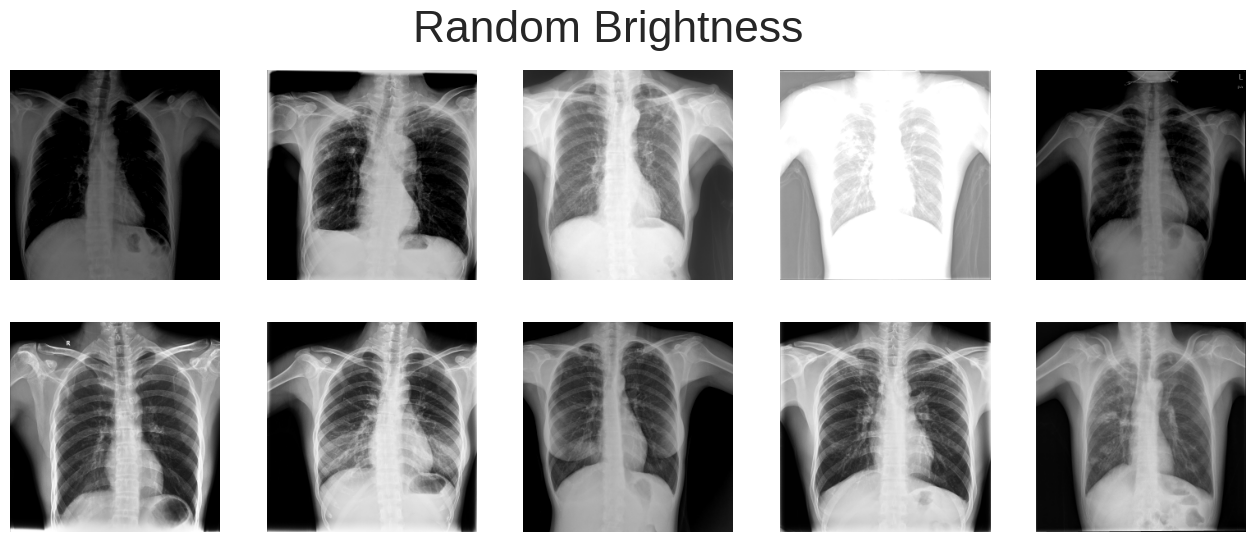

In [ ]:
# display Random Brightness augmentations
transform = A.Compose([
    A.RandomBrightness(limit=0.6)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Random Brightness', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

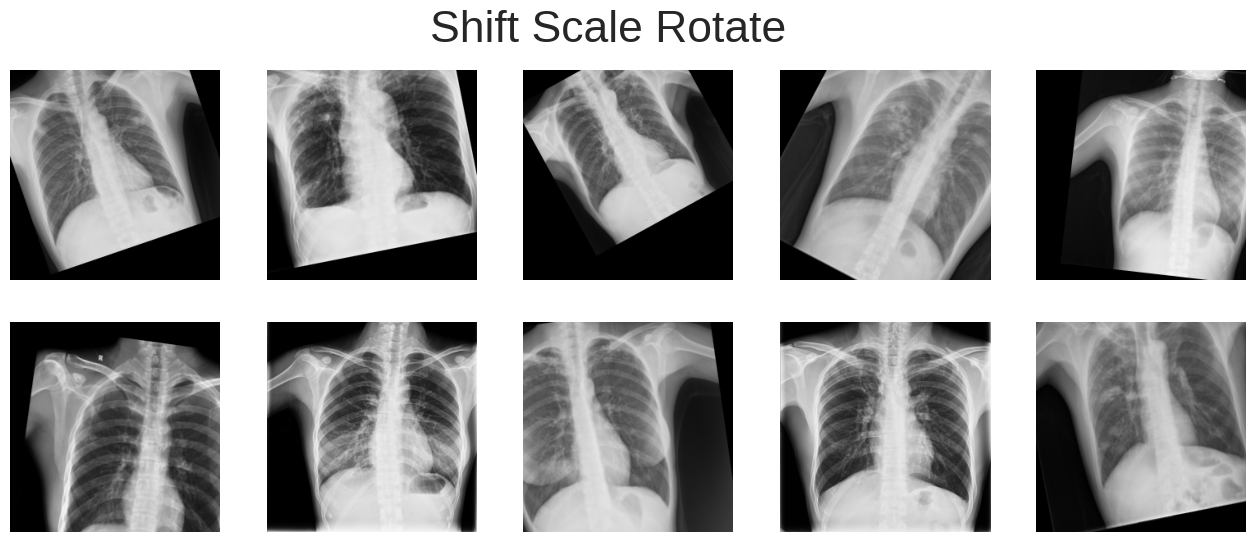

In [ ]:
# display Shift Scale Rotate augmentations
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Shift Scale Rotate', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

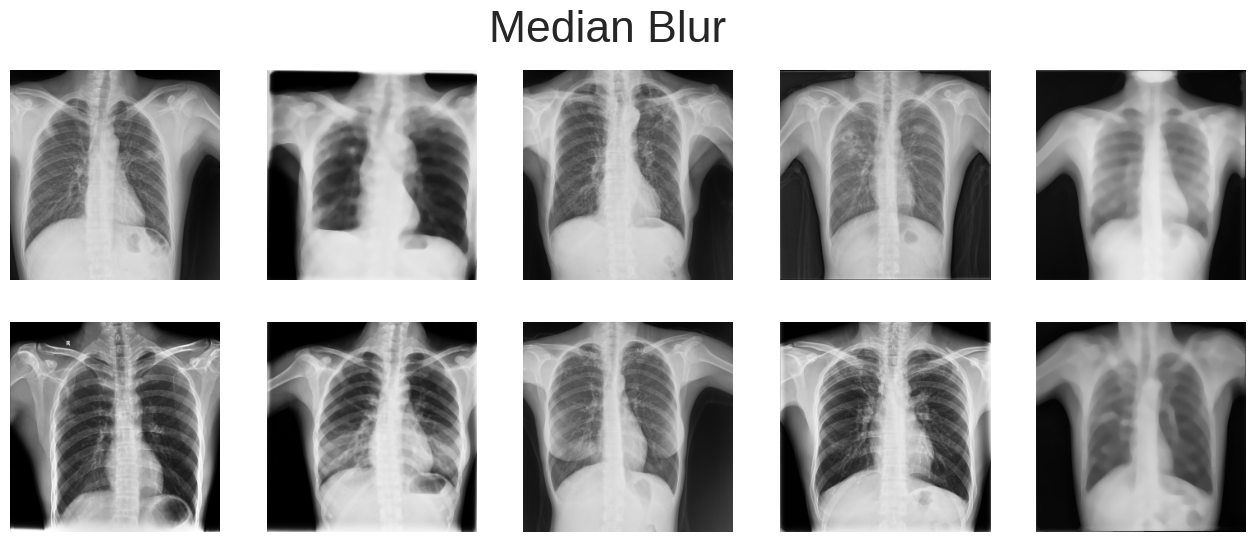

In [ ]:
# display Median Blur augmentations
transform = A.Compose([
    A.MedianBlur(blur_limit=9)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Median Blur', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

## Augmentation Pipeline

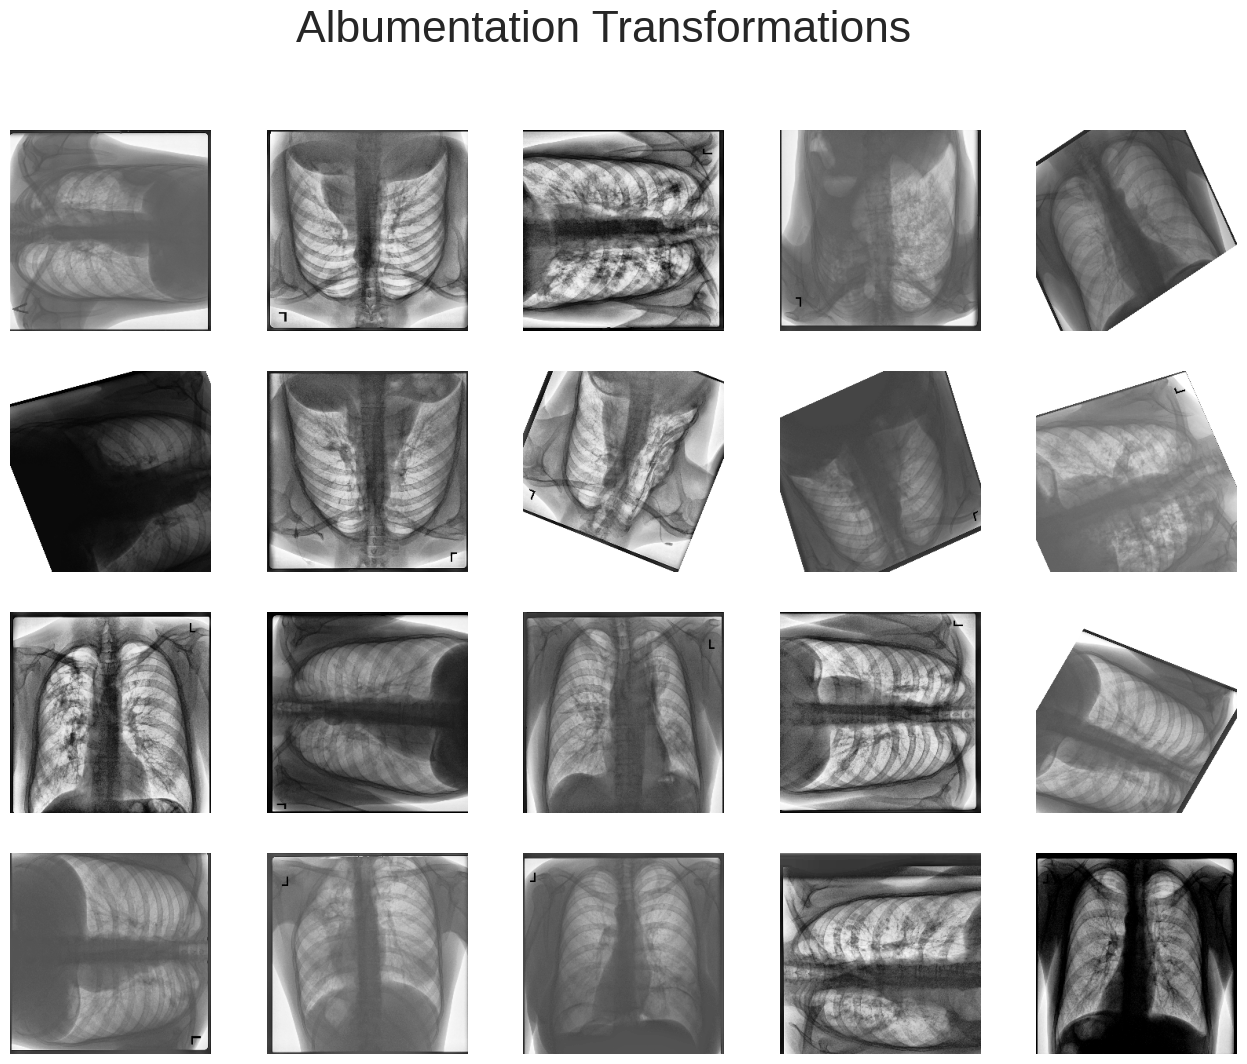

In [ ]:
# defining augmentation pipeline
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.3, p=0.5),
    A.RandomContrast(limit=0.3, p=0.5),
    # A.OneOf([
    #     A.MotionBlur(blur_limit=5),22
    #     A.MedianBlur(blur_limit=5),
    #     A.GaussianBlur(blur_limit=5),
    #     A.GaussNoise(var_limit=(5.0, 30.0)),
    # ], p=0.1),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.0),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.1),
    A.CLAHE(clip_limit=4.0, p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.4),
    A.Resize(256, 256),
    # A.Cutout(max_h_size=int(256 * 0.1), max_w_size=int(256 * 0.1), num_holes=1, p=0.2),
    # A.Normalize()
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/*.png')
path = sorted(paths)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))
plt.suptitle('Albumentation Transformations', fontsize=32)
for i in range(0, 20):
    image = np.array(Image.open(path[i]))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5

    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

